# ECS 174 HW1

In [1]:
import math
import numpy as np
import plotly.express as px
from PIL import Image 
from matplotlib import pyplot as plt

## Please do not use cv2 or scipy

In [2]:
# show and save a ndarray as an image
def img_save(img_array, file_name, title= '', show = True, cmap=None):
    
    if show:
        plt.imshow(img_array.astype(np.uint8), cmap = cmap)
        plt.title(title)
        plt.show()
    
    plt.imsave(file_name, img_array.astype(np.uint8), cmap = cmap)

In [3]:
def convolution(image, filter):
    img_convolved = np.zeros_like(image, dtype=np.float32)

    filter_size = filter.shape[0]
    filter_row  = image.shape[0]
    filter_col  = image.shape[1]
    
    # Check if image has multiple channels
    if len(image.shape) > 2:
        num_channels = image.shape[2]
    else:
        num_channels = 1
    
    ## if needed, pad image
    ##pad_image = np.pad(image, pad_width=((filter_size // 2, filter_size // 2), (filter_size // 2, filter_size // 2), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
    if num_channels > 1:
        pad_image = np.pad(image, pad_width=((filter_size // 2, filter_size // 2), (filter_size // 2, filter_size // 2), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
    else:
        pad_image = np.pad(image, pad_width=((filter_size // 2, filter_size // 2), (filter_size // 2, filter_size // 2)), mode='constant', constant_values=0).astype(np.float32)


    for i in range(filter_row):
        for j in range(filter_col):
            for k in range(num_channels):
                ##submat = pad_image[i : i + filter_size, j : j + filter_size, k]
                if num_channels > 1:
                    submat = pad_image[i : i + filter_size, j : j + filter_size, k]
                else:
                    submat = pad_image[i : i + filter_size, j : j + filter_size]

                ##img_convolved[i, j, k] = np.sum(np.multiply(submat, filter))
                if num_channels > 1:
                    img_convolved[i, j, k] = np.sum(np.multiply(submat, filter))
                else:
                    img_convolved[i, j] = np.sum(np.multiply(submat, filter))

    return img_convolved


## Q1

In [4]:
def GaussianBlurImage(image, sigma):
    ## define Gaussian filter
    filter_size = 2*int(4 * sigma + 0.5) + 1
    G_filter = np.zeros((filter_size, filter_size), np.float32)##
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            G_filter[i, j] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigma ** 2))

    ## and convolve
    img_blurred = convolution(image, G_filter)
    return img_blurred


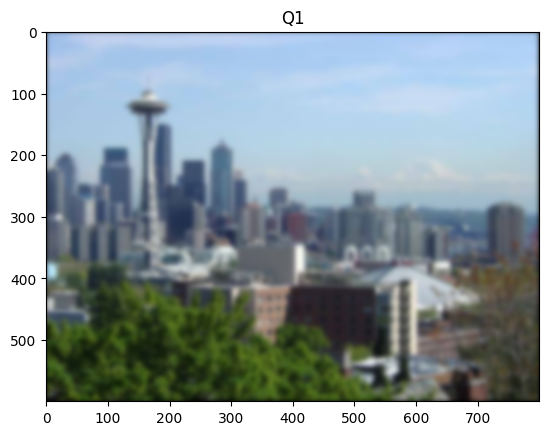

In [5]:
img_seattle = Image.open('/Users/zfxbear/Desktop/hw1_data/Seattle.jpg') ## replace path
img_seattle = np.array(img_seattle).astype(np.uint8)
img_1 = GaussianBlurImage(img_seattle, sigma=4.0)
img_save(img_1, '1.png', 'Q1', show = True)

## Q2

In [6]:
def SeparableGaussianBlurImage(image, sigma):

    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.fromfunction(
        lambda x: math.e
        ** ((-1 * (x - (filter_size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (filter_size,),
    )
    gaussian_filter = gaussian_filter / np.sum(
        gaussian_filter
    )

    ## define each filter
    filter_x = np.reshape(gaussian_filter, (1, -1))##
    
    filter_y = filter_x.T

    img_blurred = image.astype(np.float32)##
    for c in range(3):
        img_blurred[:, :, c] = np.apply_along_axis(
            lambda m: np.convolve(m, gaussian_filter, mode="same"), axis=0, arr=img_blurred[:, :, c]
        )
        img_blurred[:, :, c] = np.apply_along_axis(
            lambda m: np.convolve(m, gaussian_filter, mode="same"), axis=1, arr=img_blurred[:, :, c]
        )

    return img_blurred

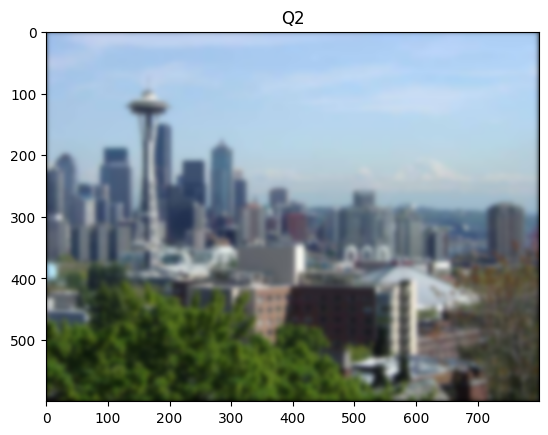

In [7]:
img_2 = SeparableGaussianBlurImage(img_seattle, sigma=4.0)
img_save(img_2, '2.png', 'Q2', show = True)

## Q3

In [8]:
# Q3
def SharpenImage(image, sigma, alpha):

    ## we can use the GaussianBlurImage from Q1
    img_blurred = GaussianBlurImage(image, sigma)
    img_sharpen = image + alpha * (image - img_blurred) ##
    img_sharpen = np.clip(img_sharpen, 0, 255).astype(np.uint8)

    return img_sharpen

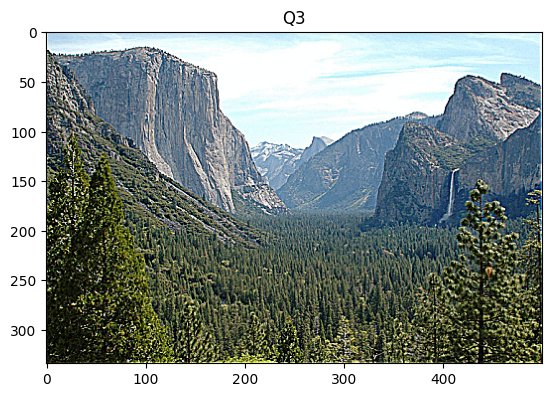

In [9]:
img_yosemite = Image.open('/Users/zfxbear/Desktop/hw1_data/Yosemite.png') ##
img_yosemite = np.array(img_yosemite).astype(np.uint8)
img_3 = SharpenImage(img_yosemite, sigma=1.0, alpha=5.0)
img_save(img_3, '4.png', 'Q3', show = True)

## Q4

In [10]:
# Q4
def SobelImage(image):
    im_filtered = np.zeros_like(image, dtype=np.float32)
   
    gx = convolution(image, np.array([[-1,0,1],[-2,0,2],[-1,0,1]]))
    gy = convolution(image, np.array([[-1,-2,-1],[0,0,0],[1,2,1]]))

      
    magnitude = np.sqrt(gx ** 2 + gy ** 2)##

    orientation = np.arctan2(gy , gx)##

    return magnitude, orientation

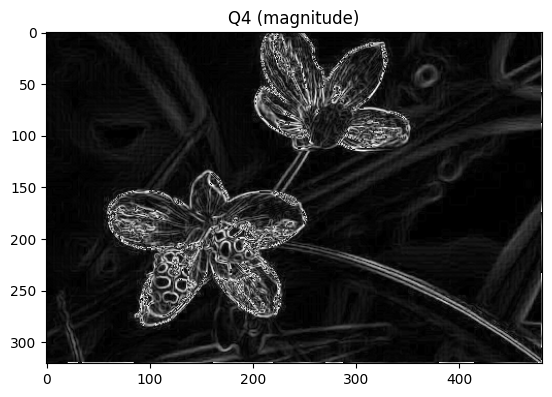

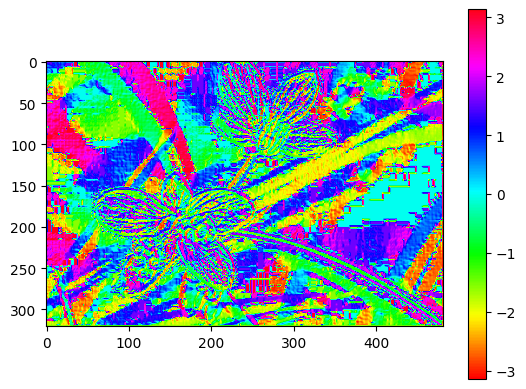

In [11]:
img_ladybug = Image.open('/Users/zfxbear/Desktop/hw1_data/LadyBug.jpg').convert('L') ##
img_ladybug = np.array(img_ladybug).astype(np.uint8)
magnitude, orientation = SobelImage(img_ladybug)

img_save(magnitude, '5a.png', 'Q4 (magnitude)', show = True, cmap = 'gray')

## orientation is represented in radians, ranging from -pi to +pi, better not normalizing or convert to uint8
plt.imshow(orientation, cmap = plt.cm.hsv) ## no astype(np.uint8) 
plt.colorbar()
plt.show()
plt.imsave('5b.png', orientation, cmap = plt.cm.hsv)

## Q5

In [12]:
# Q5
def NNInterpolation(image, x, y):
    
    x1 = int(np.floor(x))
    y1 = int(np.floor(y))

    pixel_value = image[y1,x1]##

    return pixel_value

def BilinearInterpolation(image, x, y):

    x1 = int(np.floor(x))
    y1 = int(np.floor(y))

    x2 = int(np.ceil(x))
    x2 = min(x2, image.shape[1] - 1)
    y2 = int(np.ceil(y))
    y2 = min(y2, image.shape[0] - 1)
    
    a = x  % 1
    b = y  % 1

    topleft = image[y1,x1]
    topright = image[y1,x2]
    bottomleft = image[y2,x1]
    bootomright = image[y2,x2]

    BilinearSampling = (1-a)*(1-b)*topleft + a*(1-b)*topright + (1-a)*b*bottomleft + a*b*bootomright

    pixel_value = np.round(BilinearSampling).astype(np.uint8)

    return pixel_value


def UpSampling(image, factor, interpolation):

    ## img_array.shape = (Height, Width)
    width_up = image.shape[1]*factor 
    height_up = image.shape[0]*factor

    img_upsampled = np.zeros((height_up, width_up, image.shape[2]), dtype = np.uint8)

    for i in range(height_up):
        for j in range(width_up):
            x = j / factor
            y = i / factor
            if interpolation == "Bilinear":
                img_upsampled[i][j] = BilinearInterpolation(image, x, y)
            else:
                img_upsampled[i][j] = NNInterpolation(image, x, y)
    
    return img_upsampled

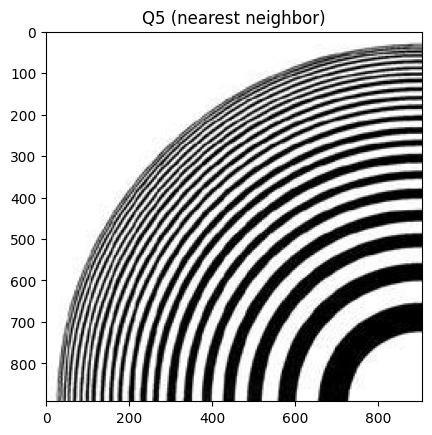

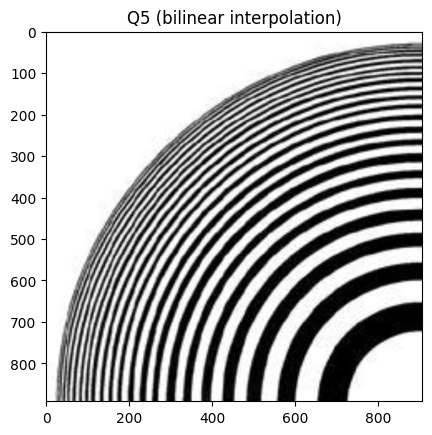

In [13]:
img_moire = Image.open('/Users/zfxbear/Desktop/hw1_data/Moire_small.jpg') ##
img_moire = np.array(img_moire).astype(np.uint8)
moire_nn = UpSampling(img_moire, factor=4, interpolation="NN")
moire_bilinear = UpSampling(img_moire, factor=4, interpolation="Bilinear")
img_save(moire_nn, '6a.png', 'Q5 (nearest neighbor)', show = True)
img_save(moire_bilinear, '6b.png', 'Q5 (bilinear interpolation)', show = True)

## Q6

In [13]:
# Q6
# All the content is roughly the same as Q1 and convolution, the main thing is SigmaI in convolution. And add a variable in bilateralImage function from GaussianBlurImage.
def convolution(image, kernel, sigmaI=None):
    img_convolved = np.zeros_like(image, dtype=np.float32)
    kernel_size = kernel.shape[0]
    image_row = image.shape[0]
    image_col = image.shape[1]
    num_channels = image.shape[2]

    pad_image = np.pad(image, pad_width=((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2), (0, 0)), mode='constant', constant_values=0).astype(np.float32)

    for i in range(image_row):
        for j in range(image_col):
            for k in range(num_channels):
                submat = pad_image[i : i + kernel_size, j : j + kernel_size, k]
                
                if sigmaI is not None:
                    
                    intensity_diff = np.exp(-np.square(submat - pad_image[i+kernel_size//2, j+kernel_size//2, k]) / (2 * np.square(sigmaI)))
                    weight = kernel * intensity_diff
                    weight /= np.sum(weight)
                else:
                    weight = kernel
                    
                img_convolved[i, j, k] = np.sum(submat * weight)

    return img_convolved

def BilateralImage(img_seattle, sigmaS, sigmaI):
    filter_size = 2*int(4 * sigmaS + 0.5) + 1
    G_filter = np.zeros((filter_size, filter_size), np.float32) 
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            G_filter[i, j] = 1 / (2 * np.pi * sigmaS ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigmaS ** 2))

    img_bilateral = convolution(img_seattle, G_filter, sigmaI)


    return img_bilateral


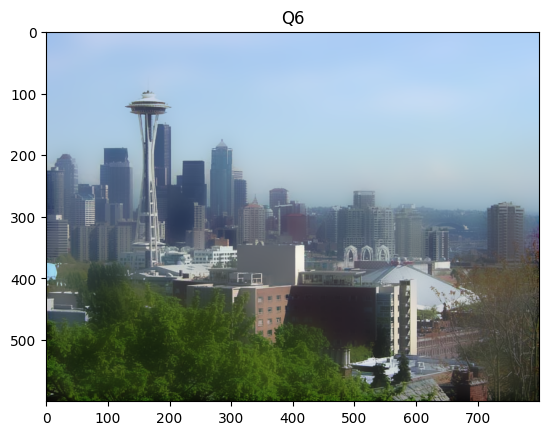

In [14]:
sigmaS = 15 ##
sigmaI = 50 ##
img_bilateral = BilateralImage(img_seattle, sigmaS, sigmaI)
img_save(img_bilateral, 'bilateral.png', 'Q6', show = True)

## Q7

In [ ]:
# Q7
def HoughTransform(): ## you need to set parameters
    ## Not particularly understanding, hope to see sample code.
    img_hough = ##
    
    return img_hough

In [ ]:
## Q7 (extra)
img_hough = HoughTransform() ## parameter
img_save(img_hough, 'hough.png', 'Q7', show = True)

## Written Q1


Moire sigma 3 
    In moiré images, there is less high-frequency content, and its features mainly present regularly repeating textures. Therefore, a relatively low sigma value is sufficient to smooth these textures to reduce artifacts and distortion during downsampling. Using a smaller sigma value can effectively reduce the high-frequency details in the image while retaining the original content information, thereby avoiding adverse effects during the downsampling process.
Seattle sigma 5 
    The Seattle image has richer and more complex high-frequency details such as buildings, trees, and other textures than the moiré image. To better preserve these details and reduce artifacts during downsampling, use a large sigma value. Larger sigma values ​​smooth high-frequency details in the image more effectively, maintaining image quality during downsampling.

## Written Q2


With an image rotated 20 degrees by 2 degrees, the output image has a fisheye effect and appears blurry. In contrast, rotating the image by 40 degrees produces a sharper image and preserves more information.      
Rotating the image multiple times by a small angle of 2 degrees does not produce the same output as rotating the image once by a larger angle of 40 degrees. The reason for this discrepancy is the information loss caused by interpolation methods during image rotation, which is inherent in image rotation operations. Every time the image is rotated, the interpolation process introduces some errors and artifacts that accumulate over multiple rotations, resulting in distorted and blurred images.Specifically, the cumulative effect of these interpolation errors becomes more pronounced when the image is rotated 20 consecutive times by 2 degrees. The output image will have a distortion effect similar to fisheye, and the clarity of the image will also be affected, and the overall image will appear blurred. This is because during each rotation, the pixels of the image are resampled and interpolated, resulting in loss of detail information.In contrast, rotating the image by 40 degrees at once can better reduce the impact of these interpolation errors on image quality. Because in this case, the image only needs to undergo one interpolation calculation, so as to retain the original image information as much as possible. As a result, a one-time rotation of 40 degrees will usually result in a sharper image with more detail preserved.

In [ ]:
def double(image):
    info = np.iinfo(image.dtype)
    return image.astype(float) / info.max  # changed np.float to float



utt_left = cv2.imread("hw2_data/uttower_left.JPG")
utt_right = cv2.imread("hw2_data/uttower_right.JPG")

# Convert images to grayscale
utt_left = cv2.cvtColor(utt_left, cv2.COLOR_BGR2GRAY)
utt_right = cv2.cvtColor(utt_right, cv2.COLOR_BGR2GRAY)

# Convert to double precision
utt_left = double(utt_left)
utt_right = double(utt_right)


def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = np.argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

##Ploting Harris Points
def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    plt.axis('off')
    plt.show()

utt_left_harris = harris(utt_left, 4, thresh=None, radius=None)
utt_right_harris = harris(utt_right, 4, thresh=None, radius=None)

utt_left_point = get_harris_points(utt_left_harris)
utt_right_point = get_harris_points(utt_right_harris)
plot_harris_points(utt_left_harris, utt_left_point)
plot_harris_points(utt_right_harris, utt_right_point)